In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
#from keras.layers.preprocessing import preprocessing_utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems
import data_gen

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models/test')
import test_fusion

In [4]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

In [6]:
!pip install qutip
import qutip as qt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 91.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# XYZ Data

In [12]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 0.83156
eta = 0.1469
gamma_s = 0.1
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [103]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)
voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_zz00_gammas0p1/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_xyz_avg100/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xx_xx00_kappa0x4/large_eps_XX00_kappa0x4_eta0_grp1000_N40_T4_dt2em8_xx_avg1000/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_xy00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg200/voltage'
#epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_zz00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg100/epsilons'

voltage = tf.saved_model.load(voltage_dir)
#epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)
epsilons = np.arange(0.0, 2.0, 0.05)

voltage = voltage[...,0,:]
print(voltage.shape)

(40, 100, 1024, 2, 3)


In [14]:
voltage_orig = voltage

In [15]:
# Compute the voltage centered differences
#voltage_diff = (voltage[:,:,2:,...] - voltage[:,:,:-2,...])/(2.0*deltat)
voltage_diff = (voltage[:,:,1:,...] - voltage[:,:,:-1,...])/(deltat)
tvec_diff = tvec[1:-1]

In [16]:
epsidx = 20
eps = epsilons[epsidx]
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0))
qtrho0 = psi0*psi0.dag()

In [104]:
ntraj = 10000
result = qt.smesolve(H, qtrho0, tvec, c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sz0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sz1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], sc_ops=[np.sqrt(0.5*eta*kappa) * sz0, np.sqrt(0.5*eta*kappa) * sz1], e_ops=[sz0,sz1], ntraj=ntraj, store_measurement=True)

10.0%. Run time:  26.41s. Est. time left: 00:00:03:57
20.0%. Run time:  45.98s. Est. time left: 00:00:03:03
30.0%. Run time:  64.46s. Est. time left: 00:00:02:30
40.0%. Run time:  84.07s. Est. time left: 00:00:02:06
50.0%. Run time: 102.67s. Est. time left: 00:00:01:42
60.0%. Run time: 123.52s. Est. time left: 00:00:01:22
70.0%. Run time: 143.12s. Est. time left: 00:00:01:01
80.0%. Run time: 162.45s. Est. time left: 00:00:00:40
90.0%. Run time: 181.72s. Est. time left: 00:00:00:20
Total run time: 200.58s


In [105]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(10000, 1024, 2)

In [106]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[100:200,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,2,:,0,2])

tf.Tensor(1.662160528689519, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=1.5991863366558463>

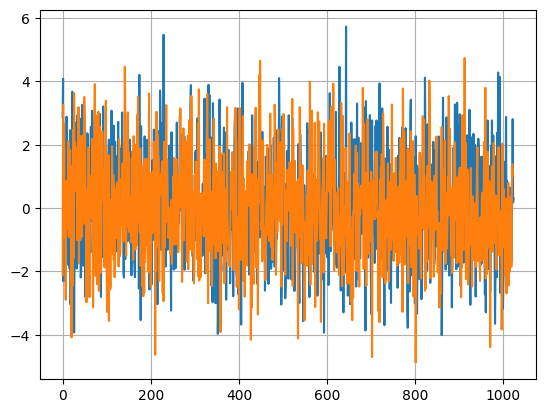

In [107]:
plt.plot(tf.reduce_mean(all_meas[100:200,:,0], axis=0))
plt.plot(voltage_diff[epsidx,2,:,0,2])
#plt.plot(tf.math.reduce_std(all_meas[:,:,0], axis=0))
#plt.plot(all_meas[0,:,0])
#plt.plot(result.expect[0])
#plt.plot(all_exp[:,4])
plt.grid()

In [108]:
all_meas.shape

(10000, 1024, 2)

In [109]:
qutip_diff0 = qutip_diff

In [110]:
qutip_diff = tf.reshape(all_meas, [-1,100,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([100, 1024, 2])

In [111]:
def diff_to_volt(diff, deltat):
  volt = np.zeros_like(diff.numpy())
  for tidx in range(diff.shape[-2]):
    if tidx < diff.shape[-2] - 1:
      volt[...,tidx+1,:] = volt[...,tidx,:] + deltat*diff[...,tidx,:]
    else:
      volt = np.concatenate([volt, volt[...,tidx:tidx+1,:] + deltat*diff[...,tidx:tidx+1,:]], axis=-2)
  return volt

In [112]:
volt = diff_to_volt(voltage_diff[...,2], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [113]:
print(volt.shape)
print(qutip_volt.shape)

(40, 100, 1024, 2)
(100, 1024, 2)


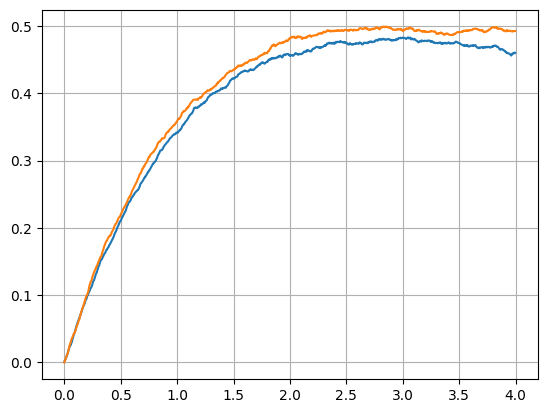

In [114]:
plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,0,2], axis=0))
plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,0], axis=0))
plt.grid()

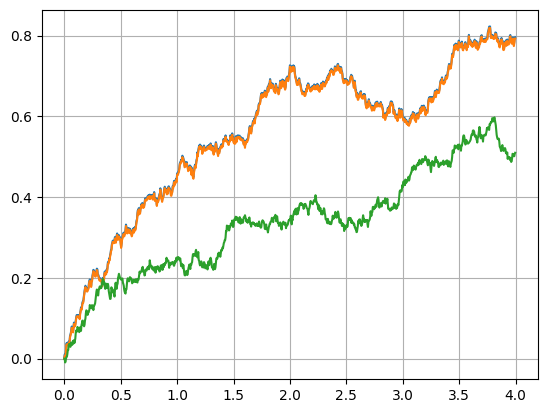

In [115]:
plt.plot(tvec, voltage[epsidx,0,:,0,2])
plt.plot(tvec, volt[epsidx,0,:,0])
plt.plot(tvec, qutip_volt[0,:,0])
plt.grid()

# XY Data

In [116]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 4.0*0.83156
eta = 0.1469
gamma_s = 0.0
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [117]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)
voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xy_xy00_kappa0x4/large_eps_XY00_kappa0x4_eta0_grp100_N40_T4_dt2em8_xy_avg200/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xx_xx00_kappa0x4/large_eps_XX00_kappa0x4_eta0_grp1000_N40_T4_dt2em8_xx_avg1000/voltage'
#voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_xy00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg200/voltage'
#epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/xyz_zz00/large_eps_ZZ00_kappa0_eta0_grp100_N40_T4_dt2em8_multimeas_avg100/epsilons'

voltage = tf.saved_model.load(voltage_dir)
#epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)
epsilons = np.arange(0.0, 2.0, 0.05)

voltage = voltage[...,0,:]
print(voltage.shape)

(40, 100, 1024, 2, 1)


In [134]:
voltage_orig = voltage

In [135]:
# Compute the voltage centered differences
#voltage_diff = (voltage[:,:,2:,...] - voltage[:,:,:-2,...])/(2.0*deltat)
voltage_diff = (voltage[:,:,1:,...] - voltage[:,:,:-1,...])/(deltat)
tvec_diff = tvec[1:-1]

In [118]:
epsidx = 20
eps = epsilons[epsidx]
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

xup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + qt.basis(2,1))
yup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + 1j*qt.basis(2,1))
psi0 = qt.tensor(xup, yup)
qtrho0 = psi0*psi0.dag()

In [121]:
ntraj = 20000
result = qt.smesolve(H, qtrho0, tvec, c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], sc_ops=[np.sqrt(0.5*eta*kappa) * sx0, np.sqrt(0.5*eta*kappa) * sy1], e_ops=[sx0,sy1], ntraj=ntraj, store_measurement=True)

10.0%. Run time:  39.93s. Est. time left: 00:00:05:59
20.0%. Run time:  82.37s. Est. time left: 00:00:05:29
30.0%. Run time: 127.09s. Est. time left: 00:00:04:56
40.0%. Run time: 203.22s. Est. time left: 00:00:05:04
50.0%. Run time: 250.08s. Est. time left: 00:00:04:10
60.0%. Run time: 296.23s. Est. time left: 00:00:03:17
70.0%. Run time: 336.98s. Est. time left: 00:00:02:24
80.0%. Run time: 377.41s. Est. time left: 00:00:01:34
90.0%. Run time: 421.12s. Est. time left: 00:00:00:46
Total run time: 461.29s


In [122]:
all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
for idx in range(len(result.measurement)):
  all_meas[idx,:,:] = result.measurement[idx]
all_meas.shape

(20000, 1024, 2)

In [123]:
print(tf.math.reduce_std(tf.reduce_mean(all_meas[100:200,:,0], axis=0)))
tf.math.reduce_std(voltage_diff[epsidx,2,:,0,2])

tf.Tensor(1.6443750200264253, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=1.5991863366558463>

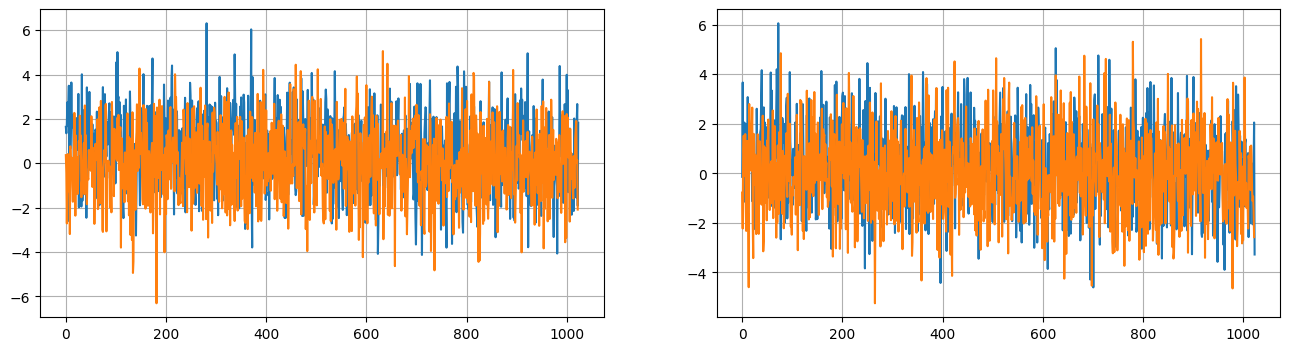

In [124]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tf.reduce_mean(all_meas[100:200,:,qidx], axis=0))
  plt.plot(voltage_diff[epsidx,2,:,qidx,0])
  #plt.plot(tf.math.reduce_std(all_meas[:,:,0], axis=0))
  #plt.plot(all_meas[0,:,0])
  #plt.plot(result.expect[0])
  #plt.plot(all_exp[:,4])
  plt.grid()

In [125]:
all_meas.shape

(20000, 1024, 2)

In [127]:
qutip_diff = tf.reshape(all_meas, [-1,200,all_meas.shape[1], all_meas.shape[2]])
qutip_diff = tf.reduce_mean(qutip_diff, axis=1)
qutip_diff.shape

TensorShape([100, 1024, 2])

In [128]:
def diff_to_volt(diff, deltat):
  volt = np.zeros_like(diff.numpy())
  for tidx in range(diff.shape[-2]):
    if tidx < diff.shape[-2] - 1:
      volt[...,tidx+1,:] = volt[...,tidx,:] + deltat*diff[...,tidx,:]
    else:
      volt = np.concatenate([volt, volt[...,tidx:tidx+1,:] + deltat*diff[...,tidx:tidx+1,:]], axis=-2)
  return volt

In [137]:
volt = diff_to_volt(voltage_diff[...,0], deltat)
qutip_volt = diff_to_volt(qutip_diff, deltat)[:,:-1,:]

In [138]:
print(volt.shape)
print(qutip_volt.shape)

(40, 100, 1024, 2)
(100, 1024, 2)


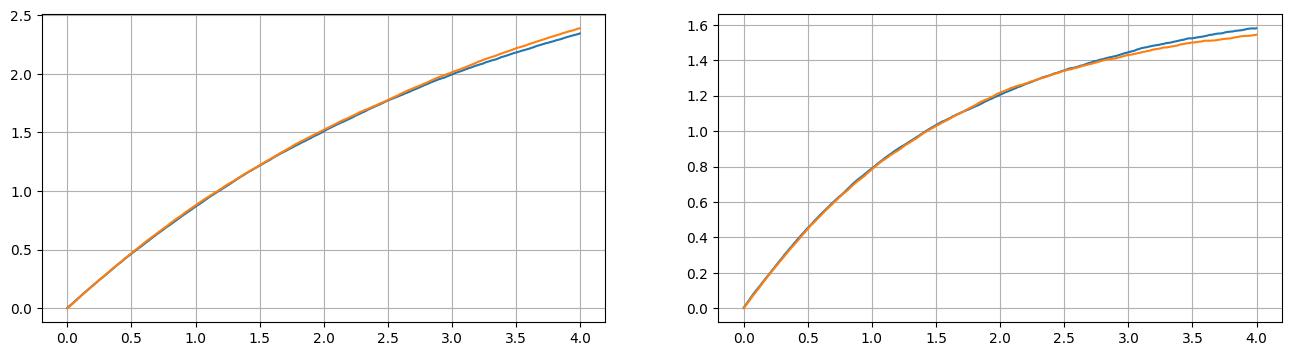

In [139]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, tf.reduce_mean(voltage[epsidx,:,:,qidx,0], axis=0))
  plt.plot(tvec, tf.reduce_mean(qutip_volt[:,:,qidx], axis=0))
  plt.grid()

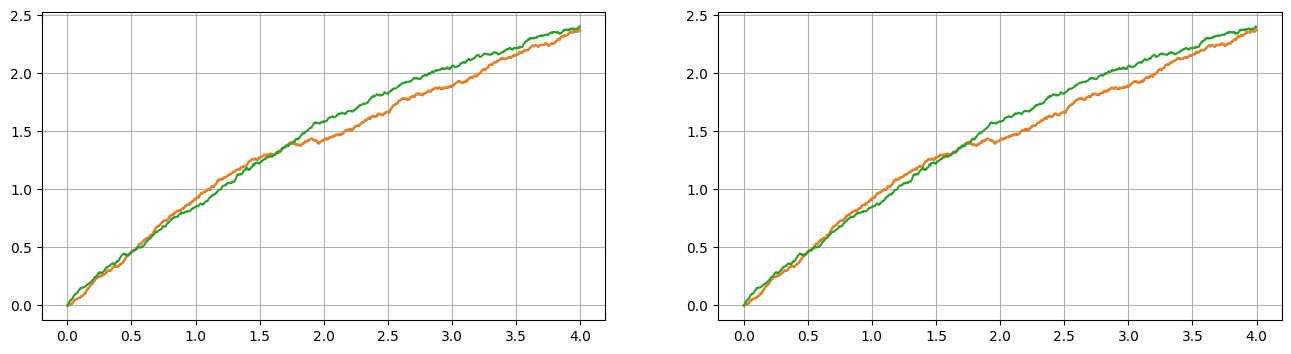

In [140]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(tvec, voltage[epsidx,0,:,0,0])
  plt.plot(tvec, volt[epsidx,0,:,0])
  plt.plot(tvec, qutip_volt[0,:,0])
  plt.grid()